In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2778
contempt    2595
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     694
contempt    649
fear        609
sad         599
neutral     572
Name: count, dtype: int64
Overall Dataset : label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64


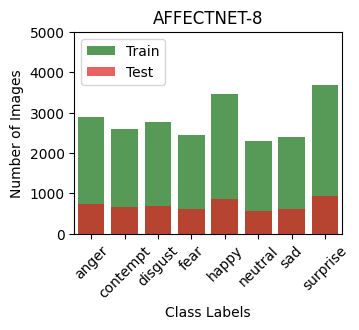

In [2]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=52, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))
print("Overall Dataset : " + str(labels_df['label'].value_counts()))

# Count the number of images per class in each dataset
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(3.45, 2.62)) 

plt.ylim(0, 5000)
sns.barplot(x=train_counts.index, y=train_counts.values, label='Train', color='green', alpha=0.7)
sns.barplot(x=val_counts.index, y=val_counts.values, label='Test', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('AFFECTNET-8')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.savefig("affectnet8_train_test_split.png", dpi=300, bbox_inches="tight")
plt.show()

Training Dataset : label
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64
Validation Dataset : label
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64
Overall Dataset : label
happy       8989
neutral     6198
sad         6077
fear        5121
angry       4953
surprise    4002
disgust      547
Name: count, dtype: int64


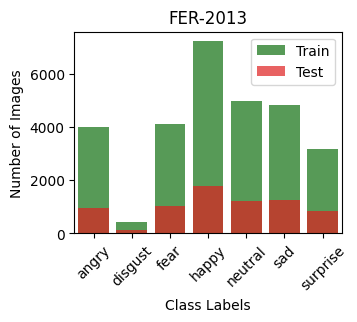

In [3]:
import glob
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
# Get all image paths and corresponding labels
train_data = []
train_dataset_path = "FER-2013/train"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(train_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    train_data.extend([(img, emotion) for img in images])

val_data = []
test_dataset_path = "FER-2013/test"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(test_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    val_data.extend([(img, emotion) for img in images])


# Convert to Pandas DataFrame for easy access
train_df = pd.DataFrame(train_data, columns=["path", "label"])
val_df = pd.DataFrame(val_data, columns=["path", "label"])
overall = pd.concat([train_df, val_df], axis=0)

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))
print("Overall Dataset : " + str(overall['label'].value_counts()))

# Count the number of images per class in each dataset
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(3.45, 2.62)) 

sns.barplot(x=train_counts.index, y=train_counts.values, label='Train', color='green', alpha=0.7)
sns.barplot(x=val_counts.index, y=val_counts.values, label='Test', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('FER-2013')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.savefig("fer2013_train_test_split.png", dpi=300, bbox_inches="tight")
plt.show()

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2777
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     695
fear        609
sad         599
neutral     572
Name: count, dtype: int64
Overall Dataset : label
surprise    4616
happy       4336
anger       3608
disgust     3472
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64


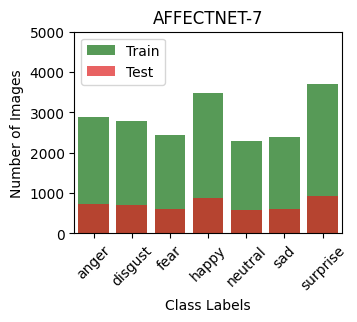

In [4]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')
labels_df = labels_df[labels_df['label'] != 'contempt']

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=52, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))
print("Overall Dataset : " + str(labels_df['label'].value_counts()))

# Count the number of images per class in each dataset
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(3.45, 2.62)) 

plt.ylim(0, 5000)
sns.barplot(x=train_counts.index, y=train_counts.values, label='Train', color='green', alpha=0.7)
sns.barplot(x=val_counts.index, y=val_counts.values, label='Test', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('AFFECTNET-7')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.savefig("affectnet7_train_test_split.png", dpi=300, bbox_inches="tight")
plt.show()

Training Dataset : label
happy       4772
neutral     2524
sad         1982
surprise    1290
disgust      717
anger        705
fear         281
Name: count, dtype: int64
Validation Dataset : label
happy       1185
neutral      680
sad          478
surprise     329
anger        162
disgust      160
fear          74
Name: count, dtype: int64
Overall Dataset : label
happy       5957
neutral     3204
sad         2460
surprise    1619
disgust      877
anger        867
fear         355
Name: count, dtype: int64


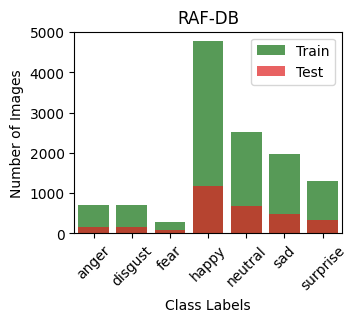

In [5]:
label_map = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "anger",
    7: "neutral"
}

# Load the dataset
train_df = pd.read_csv('raf-db/train_labels.csv')
val_df = pd.read_csv('raf-db/test_labels.csv')
train_df = train_df.rename(columns={'image': 'pth', 'label': 'label'})
val_df = val_df.rename(columns={'image': 'pth', 'label': 'label'})

BASE_PATH = "DATASET/train/"
# Function to update paths
def update_path(row):
    return os.path.join(BASE_PATH, str(row['label']), row['pth'])

# Apply function to update the 'path' column
train_df['pth'] = train_df.apply(update_path, axis=1)

BASE_PATH = "DATASET/test/"
val_df['pth'] = val_df.apply(update_path, axis=1)

train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

overall = pd.concat([train_df, val_df], axis=0)

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))
print("Overall Dataset : " + str(overall['label'].value_counts()))

# Count the number of images per class in each dataset
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(3.45, 2.62)) 

sns.barplot(x=train_counts.index, y=train_counts.values, label='Train', color='green', alpha=0.7)
sns.barplot(x=val_counts.index, y=val_counts.values, label='Test', color='red', alpha=0.7)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('RAF-DB')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.savefig("raf-db_train_test_split.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')


In [7]:
# Load the dataset
train_df = pd.read_csv('raf-db/train_labels.csv')
val_df = pd.read_csv('raf-db/test_labels.csv')
train_df = train_df.rename(columns={'image': 'pth', 'label': 'label'})
val_df = val_df.rename(columns={'image': 'pth', 'label': 'label'})

BASE_PATH = "DATASET/train/"
# Function to update paths
def update_path(row):
    return os.path.join(BASE_PATH, str(row['label']), row['pth'])

# Apply function to update the 'path' column
train_df['pth'] = train_df.apply(update_path, axis=1)

BASE_PATH = "DATASET/test/"
val_df['pth'] = val_df.apply(update_path, axis=1)

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 224

Training Dataset : label
4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: count, dtype: int64
Validation Dataset : label
4    1185
7     680
5     478
1     329
6     162
3     160
2      74
Name: count, dtype: int64


I0000 00:00:1742530881.213957 1080539 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742530881.340775 1080780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [8]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 7
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('RAF-DB-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1742530881.400349 1080775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_1[0][0]']                
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_1[0][0]']                
                                                                                     

In [9]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def preprocess_and_predict_rafdb(model, dataframe, dataset_path="raf-db"):

    images = []
    labels = []
    
    num_classes = 7 

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join(dataset_path, str(row['pth']))  # Construct full image path
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Detect and crop face
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image

            # Convert label to one-hot encoding
            labels.append(to_categorical(row['label'] - 1, num_classes=num_classes))  # Convert 1-7 to index 0-6

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the trained model
    y_pred = model.predict(images)

    # Get predicted class indices
    predicted_labels = np.argmax(y_pred, axis=-1)  # Find the highest probability class

    return labels, predicted_labels  # Return true one-hot labels and predicted indices


In [11]:
model.load_weights('RAF-DB-Ensemble-Vision.h5')

In [12]:
true_labels, predicted_labels = preprocess_and_predict_rafdb(model, val_df)
true_class_labels = np.argmax(true_labels, axis=-1)  # Convert one-hot labels to class indices


96/96 [==============================] - 28s 225ms/step


In [13]:
from sklearn.metrics import classification_report
emotions = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'anger', 'neutral']

# Print classification report
print("Classification Report:")
print(classification_report(true_class_labels, predicted_labels, target_names=emotions))


Classification Report:
              precision    recall  f1-score   support

    surprise       0.87      0.82      0.84       329
        fear       0.65      0.62      0.63        74
     disgust       0.62      0.60      0.61       160
       happy       0.91      0.95      0.93      1185
         sad       0.77      0.88      0.82       478
       anger       0.71      0.87      0.78       162
     neutral       0.88      0.73      0.80       680

    accuracy                           0.84      3068
   macro avg       0.77      0.78      0.77      3068
weighted avg       0.85      0.84      0.84      3068



In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_class_labels, predicted_labels)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8429


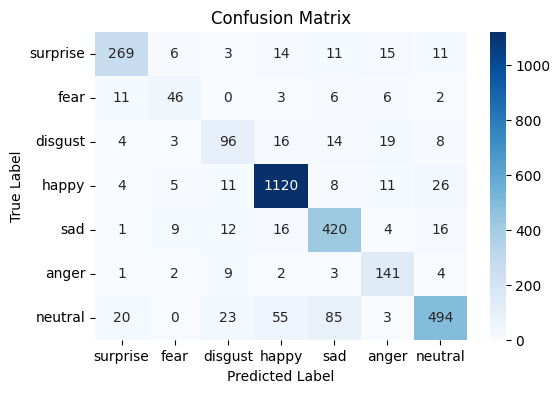

In [15]:
# Generate confusion matrix
cm = confusion_matrix(true_class_labels, predicted_labels)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

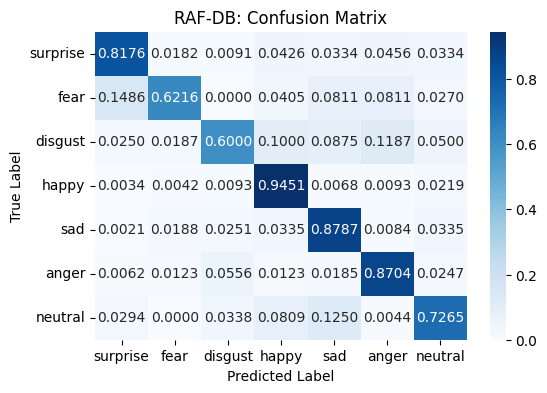

In [16]:
# Normalize by row (true class count)
cm_percentage = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percentage, annot=True, fmt=".4f", cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RAF-DB: Confusion Matrix")
plt.show()


Binary Classification Report for surprise vs Others:
              precision    recall  f1-score   support

Not surprise       0.98      0.99      0.98      2739
    surprise       0.87      0.82      0.84       329

    accuracy                           0.97      3068
   macro avg       0.92      0.90      0.91      3068
weighted avg       0.97      0.97      0.97      3068



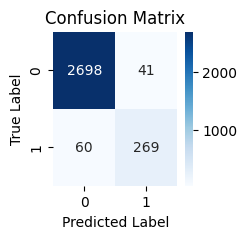

Accuracy: 0.967080

Binary Classification Report for fear vs Others:
              precision    recall  f1-score   support

    Not fear       0.99      0.99      0.99      2994
        fear       0.65      0.62      0.63        74

    accuracy                           0.98      3068
   macro avg       0.82      0.81      0.81      3068
weighted avg       0.98      0.98      0.98      3068



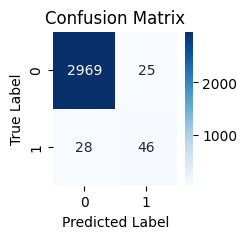

Accuracy: 0.982725

Binary Classification Report for disgust vs Others:
              precision    recall  f1-score   support

 Not disgust       0.98      0.98      0.98      2908
     disgust       0.62      0.60      0.61       160

    accuracy                           0.96      3068
   macro avg       0.80      0.79      0.80      3068
weighted avg       0.96      0.96      0.96      3068



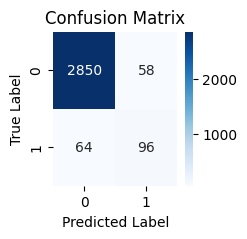

Accuracy: 0.960235

Binary Classification Report for happy vs Others:
              precision    recall  f1-score   support

   Not happy       0.96      0.94      0.95      1883
       happy       0.91      0.95      0.93      1185

    accuracy                           0.94      3068
   macro avg       0.94      0.94      0.94      3068
weighted avg       0.94      0.94      0.94      3068



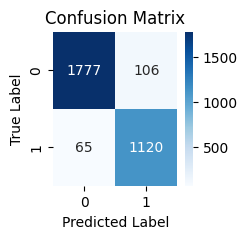

Accuracy: 0.944263

Binary Classification Report for sad vs Others:
              precision    recall  f1-score   support

     Not sad       0.98      0.95      0.96      2590
         sad       0.77      0.88      0.82       478

    accuracy                           0.94      3068
   macro avg       0.87      0.91      0.89      3068
weighted avg       0.94      0.94      0.94      3068



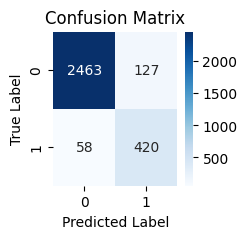

Accuracy: 0.939700

Binary Classification Report for anger vs Others:
              precision    recall  f1-score   support

   Not anger       0.99      0.98      0.99      2906
       anger       0.71      0.87      0.78       162

    accuracy                           0.97      3068
   macro avg       0.85      0.93      0.88      3068
weighted avg       0.98      0.97      0.98      3068



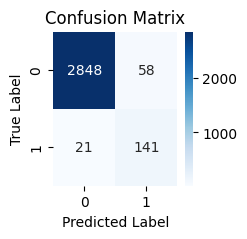

Accuracy: 0.974250

Binary Classification Report for neutral vs Others:
              precision    recall  f1-score   support

 Not neutral       0.93      0.97      0.95      2388
     neutral       0.88      0.73      0.80       680

    accuracy                           0.92      3068
   macro avg       0.90      0.85      0.87      3068
weighted avg       0.92      0.92      0.91      3068



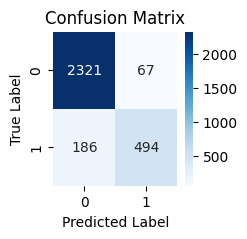

Accuracy: 0.917536


In [17]:
# Iterate over each emotion and compute binary classification metrics
for i, emotion in enumerate(emotions):
    binary_true_labels = (np.array(true_class_labels) == i).astype(int)  # 1 for current emotion, 0 for others
    binary_pred_labels = (np.array(predicted_labels) == i).astype(int)
    
    # Compute and print classification report
    print(f"\nBinary Classification Report for {emotion} vs Others:")
    print(classification_report(binary_true_labels, binary_pred_labels, target_names=[f'Not {emotion}', emotion]))

    # Generate confusion matrix
    cm = confusion_matrix(binary_true_labels, binary_pred_labels)
    
    # Plot using seaborn
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    # Compute and print accuracy to 6 decimal places
    accuracy = accuracy_score(binary_true_labels, binary_pred_labels)
    print(f"Accuracy: {accuracy:.6f}")

In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')


In [19]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=52, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 224

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2778
contempt    2595
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     694
contempt    649
fear        609
sad         599
neutral     572
Name: count, dtype: int64


I0000 00:00:1742530963.550387 1080539 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742530963.559458 1081961 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [20]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

In [21]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 8
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('AffectNet8-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


W0000 00:00:1742530963.587163 1081955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_8[0][0]']                
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_8[0][0]']                
                                                                                     

In [22]:
import os
import cv2
import numpy as np

def preprocess_and_predict_concatenated_model(model, dataframe):
    images = []
    labels = []

    # List of emotion labels corresponding to each model output
    emotion_labels = ['anger', 'contempt', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join('AffectNet', row['pth'])
        image = cv2.imread(img_path)

        # Apply face detection and cropping
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image to [0, 1]
            
            # Convert label to binary vector for each emotion
            labels.append([1 if row['label'] == emotion else 0 for emotion in emotion_labels])

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the concatenated model
    y_pred = model.predict(images)

    # Use argmax to find the index of the highest output for each prediction
    predicted_indices = np.argmax(y_pred, axis=-1)  # Get index of the highest value (emotion)

    # Map the predicted indices to emotion labels
    predicted_emotions = [emotion_labels[i] for i in predicted_indices]

    return labels, predicted_emotions  # Return both true labels and predicted emotions


In [23]:
model.load_weights('AffectNet8-Ensemble-Vision.h5')

In [24]:
y_true, y_pred_classes = preprocess_and_predict_concatenated_model(model, val_df)

177/177 [==============================] - 43s 220ms/step


In [25]:
# Convert true labels from binary vectors to emotion labels
emotion_labels = ['anger', 'contempt', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
y_true_labels = [' '.join([emotion_labels[i] for i, val in enumerate(row) if val == 1]) for row in y_true]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.55      0.66       722
    contempt       0.69      0.76      0.72       649
     disgust       0.68      0.72      0.70       694
        fear       0.90      0.59      0.71       609
       happy       0.89      0.84      0.86       867
     neutral       0.55      0.73      0.62       572
         sad       0.62      0.75      0.68       599
    surprise       0.74      0.80      0.77       923

    accuracy                           0.73      5635
   macro avg       0.74      0.72      0.72      5635
weighted avg       0.75      0.73      0.73      5635



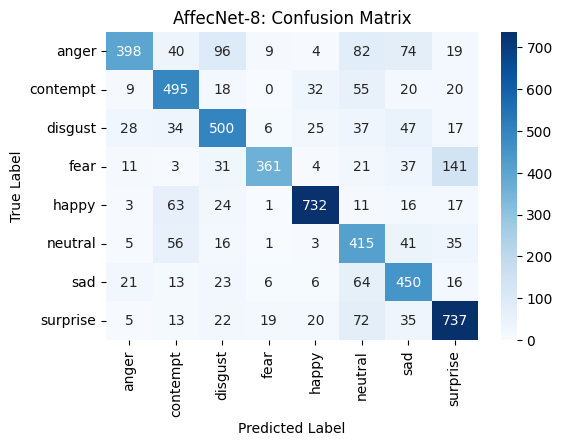

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AffecNet-8: Confusion Matrix")
plt.show()

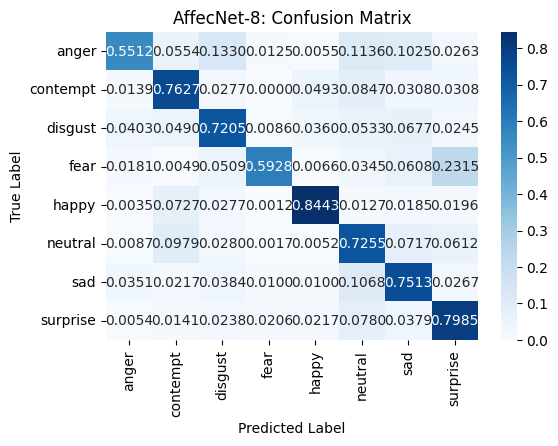

In [27]:
# Normalize by row (true class count)
cm_percentage = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percentage, annot=True, fmt=".4f", cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AffecNet-8: Confusion Matrix")
plt.show()


Binary Classification Report for anger vs Others:
              precision    recall  f1-score   support

   Not anger       0.94      0.98      0.96      4913
       anger       0.83      0.55      0.66       722

    accuracy                           0.93      5635
   macro avg       0.88      0.77      0.81      5635
weighted avg       0.92      0.93      0.92      5635



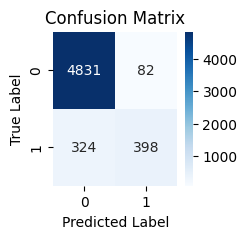

Accuracy: 0.927950

Binary Classification Report for contempt vs Others:
              precision    recall  f1-score   support

Not contempt       0.97      0.96      0.96      4986
    contempt       0.69      0.76      0.72       649

    accuracy                           0.93      5635
   macro avg       0.83      0.86      0.84      5635
weighted avg       0.94      0.93      0.93      5635



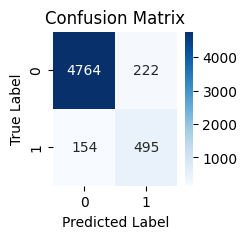

Accuracy: 0.933274

Binary Classification Report for disgust vs Others:
              precision    recall  f1-score   support

 Not disgust       0.96      0.95      0.96      4941
     disgust       0.68      0.72      0.70       694

    accuracy                           0.92      5635
   macro avg       0.82      0.84      0.83      5635
weighted avg       0.93      0.92      0.93      5635



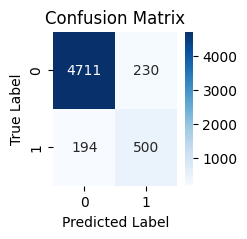

Accuracy: 0.924756

Binary Classification Report for fear vs Others:
              precision    recall  f1-score   support

    Not fear       0.95      0.99      0.97      5026
        fear       0.90      0.59      0.71       609

    accuracy                           0.95      5635
   macro avg       0.92      0.79      0.84      5635
weighted avg       0.95      0.95      0.94      5635



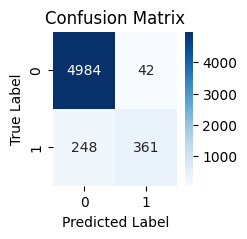

Accuracy: 0.948536

Binary Classification Report for happy vs Others:
              precision    recall  f1-score   support

   Not happy       0.97      0.98      0.98      4768
       happy       0.89      0.84      0.86       867

    accuracy                           0.96      5635
   macro avg       0.93      0.91      0.92      5635
weighted avg       0.96      0.96      0.96      5635



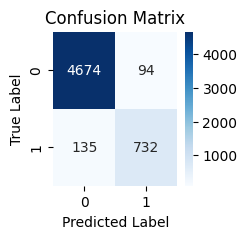

Accuracy: 0.959361

Binary Classification Report for neutral vs Others:
              precision    recall  f1-score   support

 Not neutral       0.97      0.93      0.95      5063
     neutral       0.55      0.73      0.62       572

    accuracy                           0.91      5635
   macro avg       0.76      0.83      0.79      5635
weighted avg       0.93      0.91      0.92      5635



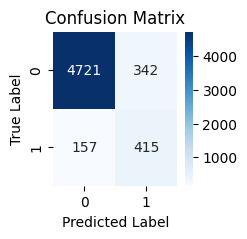

Accuracy: 0.911446

Binary Classification Report for sad vs Others:
              precision    recall  f1-score   support

     Not sad       0.97      0.95      0.96      5036
         sad       0.62      0.75      0.68       599

    accuracy                           0.93      5635
   macro avg       0.80      0.85      0.82      5635
weighted avg       0.93      0.93      0.93      5635



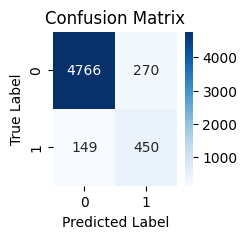

Accuracy: 0.925643

Binary Classification Report for surprise vs Others:
              precision    recall  f1-score   support

Not surprise       0.96      0.94      0.95      4712
    surprise       0.74      0.80      0.77       923

    accuracy                           0.92      5635
   macro avg       0.85      0.87      0.86      5635
weighted avg       0.92      0.92      0.92      5635



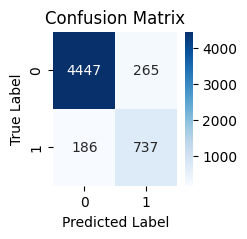

Accuracy: 0.919965


In [28]:
# Iterate over each emotion and compute binary classification metrics
y_true_indices = np.array([emotion_labels.index(label) for label in y_true_labels])
y_pred_indices = np.array([emotion_labels.index(label) for label in y_pred_classes])
for i, emotion in enumerate(emotion_labels):
    binary_true_labels = (y_true_indices == i).astype(int)
    binary_pred_labels = (y_pred_indices == i).astype(int)

    # Compute and print classification report
    print(f"\nBinary Classification Report for {emotion} vs Others:")
    print(classification_report(binary_true_labels, binary_pred_labels, target_names=[f'Not {emotion}', emotion]))
    
    # Generate confusion matrix
    cm = confusion_matrix(binary_true_labels, binary_pred_labels)
    
    # Plot using seaborn
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Compute and print accuracy to 6 decimal places
    accuracy = accuracy_score(binary_true_labels, binary_pred_labels)
    print(f"Accuracy: {accuracy:.6f}")

In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')


In [30]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')
labels_df = labels_df[labels_df['label'] != 'contempt']

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=52, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 224

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2777
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     695
fear        609
sad         599
neutral     572
Name: count, dtype: int64


I0000 00:00:1742531116.359417 1080539 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742531116.376973 1083955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [31]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

In [32]:
# Define emotion labels
emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(emotion_labels)  # 7 classes

W0000 00:00:1742531116.411712 1083951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [33]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 7
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('AffectNet7-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_15[0][0]']               
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_15[0][0]']               
                                                                                     

In [34]:
import os
import cv2
import numpy as np

def preprocess_and_predict_concatenated_model(model, dataframe):
    images = []
    labels = []

    # List of emotion labels corresponding to each model output
    emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join('AffectNet', row['pth']) 
        image = cv2.imread(img_path)

        # Apply face detection and cropping
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image to [0, 1]
            
            # Convert label to binary vector for each emotion
            labels.append([1 if row['label'] == emotion else 0 for emotion in emotion_labels])

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the concatenated model
    y_pred = model.predict(images)

    # Use argmax to find the index of the highest output for each prediction
    predicted_indices = np.argmax(y_pred, axis=-1)  # Get index of the highest value (emotion)

    # Map the predicted indices to emotion labels
    predicted_emotions = [emotion_labels[i] for i in predicted_indices]

    return labels, predicted_emotions  # Return both true labels and predicted emotions


In [35]:
model.load_weights('AffectNet7-Ensemble-Vision.h5')

In [36]:
y_true, y_pred_classes = preprocess_and_predict_concatenated_model(model, val_df)

156/156 [==============================] - 38s 218ms/step


In [37]:
# Convert true labels from binary vectors to emotion labels
emotion_labels = ['anger', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
y_true_labels = [' '.join([emotion_labels[i] for i, val in enumerate(row) if val == 1]) for row in y_true]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

       anger       0.71      0.79      0.75       722
     disgust       0.79      0.52      0.63       695
        fear       0.70      0.76      0.73       609
       happy       0.80      0.97      0.88       867
     neutral       0.70      0.72      0.71       572
         sad       0.76      0.62      0.68       599
    surprise       0.75      0.76      0.76       923

    accuracy                           0.75      4987
   macro avg       0.75      0.74      0.73      4987
weighted avg       0.75      0.75      0.74      4987



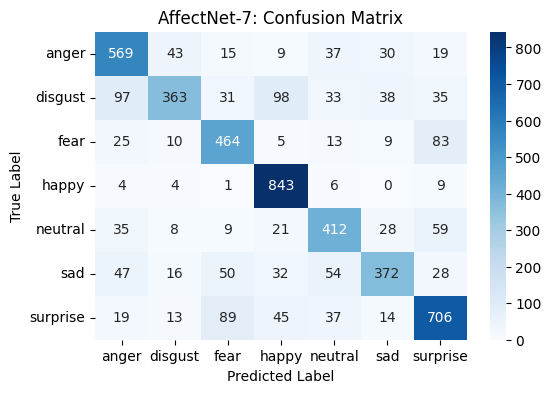

In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)
emotion_labels = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AffectNet-7: Confusion Matrix")
plt.show()

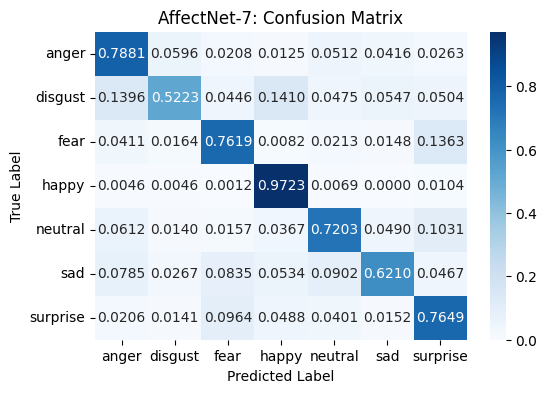

In [39]:
# Normalize by row (true class count)
cm_percentage = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percentage, annot=True, fmt=".4f", cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("AffectNet-7: Confusion Matrix")
plt.show()


Binary Classification Report for anger vs Others:
              precision    recall  f1-score   support

   Not anger       0.96      0.95      0.96      4265
       anger       0.71      0.79      0.75       722

    accuracy                           0.92      4987
   macro avg       0.84      0.87      0.85      4987
weighted avg       0.93      0.92      0.93      4987



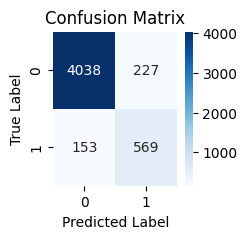

Accuracy: 0.923802

Binary Classification Report for disgust vs Others:
              precision    recall  f1-score   support

 Not disgust       0.93      0.98      0.95      4292
     disgust       0.79      0.52      0.63       695

    accuracy                           0.91      4987
   macro avg       0.86      0.75      0.79      4987
weighted avg       0.91      0.91      0.91      4987



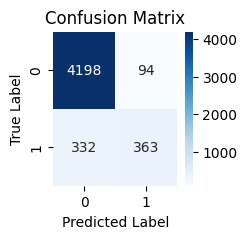

Accuracy: 0.914578

Binary Classification Report for fear vs Others:
              precision    recall  f1-score   support

    Not fear       0.97      0.96      0.96      4378
        fear       0.70      0.76      0.73       609

    accuracy                           0.93      4987
   macro avg       0.84      0.86      0.85      4987
weighted avg       0.93      0.93      0.93      4987



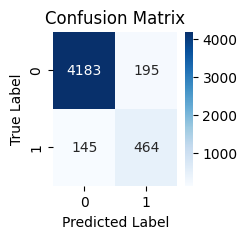

Accuracy: 0.931823

Binary Classification Report for happy vs Others:
              precision    recall  f1-score   support

   Not happy       0.99      0.95      0.97      4120
       happy       0.80      0.97      0.88       867

    accuracy                           0.95      4987
   macro avg       0.90      0.96      0.92      4987
weighted avg       0.96      0.95      0.95      4987



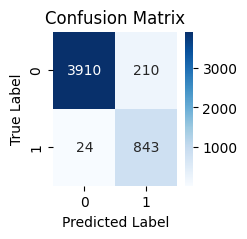

Accuracy: 0.953078

Binary Classification Report for neutral vs Others:
              precision    recall  f1-score   support

 Not neutral       0.96      0.96      0.96      4415
     neutral       0.70      0.72      0.71       572

    accuracy                           0.93      4987
   macro avg       0.83      0.84      0.83      4987
weighted avg       0.93      0.93      0.93      4987



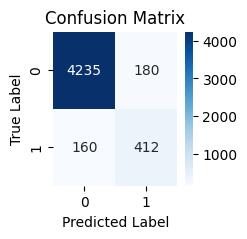

Accuracy: 0.931823

Binary Classification Report for sad vs Others:
              precision    recall  f1-score   support

     Not sad       0.95      0.97      0.96      4388
         sad       0.76      0.62      0.68       599

    accuracy                           0.93      4987
   macro avg       0.85      0.80      0.82      4987
weighted avg       0.93      0.93      0.93      4987



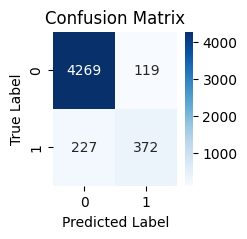

Accuracy: 0.930620

Binary Classification Report for surprise vs Others:
              precision    recall  f1-score   support

Not surprise       0.95      0.94      0.94      4064
    surprise       0.75      0.76      0.76       923

    accuracy                           0.91      4987
   macro avg       0.85      0.85      0.85      4987
weighted avg       0.91      0.91      0.91      4987



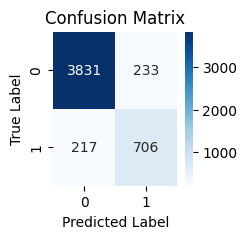

Accuracy: 0.909765


In [40]:
# Iterate over each emotion and compute binary classification metrics
y_true_indices = np.array([emotion_labels.index(label) for label in y_true_labels])
y_pred_indices = np.array([emotion_labels.index(label) for label in y_pred_classes])
for i, emotion in enumerate(emotion_labels):
    binary_true_labels = (y_true_indices == i).astype(int)
    binary_pred_labels = (y_pred_indices == i).astype(int)

    # Compute and print classification report
    print(f"\nBinary Classification Report for {emotion} vs Others:")
    print(classification_report(binary_true_labels, binary_pred_labels, target_names=[f'Not {emotion}', emotion]))
    
    # Generate confusion matrix
    cm = confusion_matrix(binary_true_labels, binary_pred_labels)
    
    # Plot using seaborn
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Compute and print accuracy to 6 decimal places
    accuracy = accuracy_score(binary_true_labels, binary_pred_labels)
    print(f"Accuracy: {accuracy:.6f}")

In [41]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')

In [42]:
IMG_SIZE = 224  # FER2013 image size
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)  # 7 emotion classes

In [43]:
# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

I0000 00:00:1742531248.098460 1080539 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742531248.120763 1085691 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [44]:
lock = threading.Lock()

def detect_and_crop_face(image):
    """Detects and crops the face using MediaPipe BlazeFace, then resizes to target size."""
    with lock:
        if image is None:
            print("Empty image")
            return None
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
                
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
                
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))

        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))


W0000 00:00:1742531248.160983 1085685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [45]:
# Define emotion labels
emotion_labels = ['0', '1', '2', '3', '4', '5', '6']
num_classes = len(emotion_labels)  # 7 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = row["path"]  
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = str(row['label'])
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str)

                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Handle remaining samples
        if len(batch_images) > 0:
            current_size = len(batch_images)
            indices = np.random.randint(0, current_size, size=batch_size - current_size)
            for idx in indices:
                batch_images.append(batch_images[idx])
                batch_labels.append(batch_labels[idx])
            
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


In [46]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 7
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('FER-2013-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_22[0][0]']               
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_22[0][0]']               
                                                                                     

In [47]:
import glob

# Get all image paths and corresponding labels
train_data = []
train_dataset_path = "FER-2013/train"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(train_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    train_data.extend([(img, label) for img in images])

val_data = []
test_dataset_path = "FER-2013/test"
for label, emotion in enumerate(EMOTION_FOLDERS):
    emotion_folder = os.path.join(test_dataset_path, emotion)
    images = glob.glob(os.path.join(emotion_folder, "*"))
    val_data.extend([(img, label) for img in images])


# Convert to Pandas DataFrame for easy access
train_df = pd.DataFrame(train_data, columns=["path", "label"])
val_df = pd.DataFrame(val_data, columns=["path", "label"])

In [48]:
model.load_weights('FER-2013-Ensemble-Vision.h5')

In [49]:
# Path to test directory
TEST_DIR = "FER-2013/test"
EMOTION_FOLDERS = ['angry', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(EMOTION_FOLDERS)

def load_test_data(test_dir):
    """Loads all test images and their labels into memory."""
    images, labels = [], []

    for label, emotion in enumerate(EMOTION_FOLDERS):
        emotion_folder = os.path.join(test_dir, emotion)
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale
            if image is None:
                continue

            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to match model input size
            image = np.stack((image,)*3, axis=-1)  # Convert to 3-channel
            images.append(image / 255.0)  # Normalize pixel values
            labels.append(label)  # Store label as an integer

    return np.array(images), to_categorical(labels, num_classes=num_classes)

# Load test data
X_test, y_test = load_test_data(TEST_DIR)

print(f"Loaded {X_test.shape[0]} test images with shape {X_test.shape[1:]}")

Loaded 7178 test images with shape (224, 224, 3)


In [50]:
# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

225/225 [==============================] - 54s 219ms/step


In [51]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=EMOTION_FOLDERS))

Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.58      0.59       958
     disgust       0.75      0.36      0.49       111
         sad       0.50      0.64      0.56      1247
       happy       0.88      0.84      0.86      1774
        fear       0.65      0.29      0.40      1024
     neutral       0.50      0.75      0.60      1233
    surprise       0.85      0.64      0.73       831

    accuracy                           0.65      7178
   macro avg       0.68      0.59      0.61      7178
weighted avg       0.68      0.65      0.64      7178



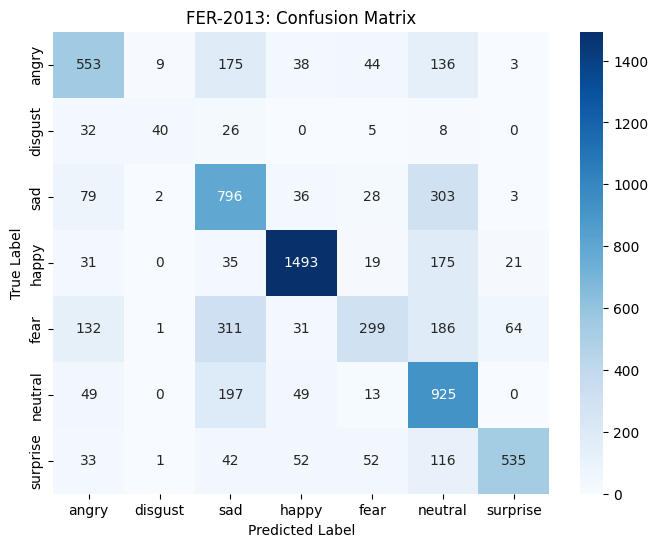

In [52]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTION_FOLDERS, yticklabels=EMOTION_FOLDERS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("FER-2013: Confusion Matrix")
plt.show()

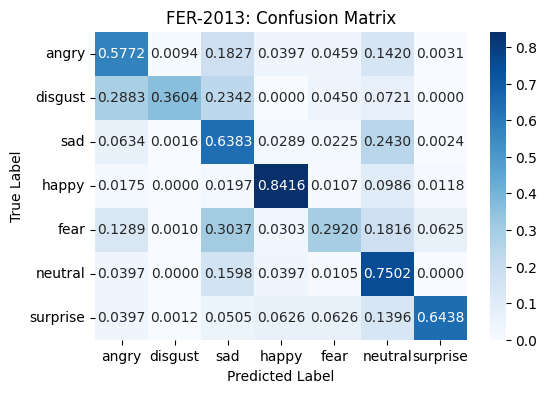

In [53]:
  # Normalize by row (true class count)
cm_percentage = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1, keepdims=True)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percentage, annot=True, fmt=".4f", cmap='Blues', xticklabels=EMOTION_FOLDERS, yticklabels=EMOTION_FOLDERS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("FER-2013: Confusion Matrix")
plt.show()


Binary Classification Report for angry vs Others:
              precision    recall  f1-score   support

   Not angry       0.94      0.94      0.94      6220
       angry       0.61      0.58      0.59       958

    accuracy                           0.89      7178
   macro avg       0.77      0.76      0.77      7178
weighted avg       0.89      0.89      0.89      7178



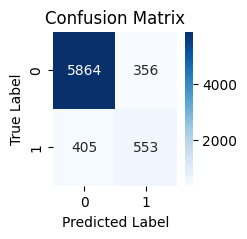

Accuracy: 0.893982

Binary Classification Report for disgust vs Others:
              precision    recall  f1-score   support

 Not disgust       0.99      1.00      0.99      7067
     disgust       0.75      0.36      0.49       111

    accuracy                           0.99      7178
   macro avg       0.87      0.68      0.74      7178
weighted avg       0.99      0.99      0.99      7178



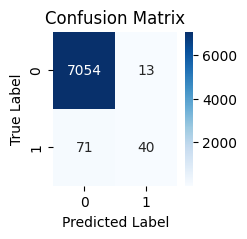

Accuracy: 0.988298

Binary Classification Report for sad vs Others:
              precision    recall  f1-score   support

     Not sad       0.92      0.87      0.89      5931
         sad       0.50      0.64      0.56      1247

    accuracy                           0.83      7178
   macro avg       0.71      0.75      0.73      7178
weighted avg       0.85      0.83      0.84      7178



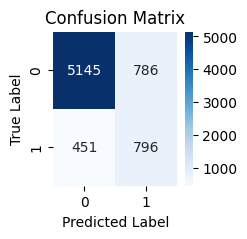

Accuracy: 0.827668

Binary Classification Report for happy vs Others:
              precision    recall  f1-score   support

   Not happy       0.95      0.96      0.96      5404
       happy       0.88      0.84      0.86      1774

    accuracy                           0.93      7178
   macro avg       0.91      0.90      0.91      7178
weighted avg       0.93      0.93      0.93      7178



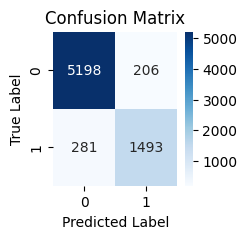

Accuracy: 0.932154

Binary Classification Report for fear vs Others:
              precision    recall  f1-score   support

    Not fear       0.89      0.97      0.93      6154
        fear       0.65      0.29      0.40      1024

    accuracy                           0.88      7178
   macro avg       0.77      0.63      0.67      7178
weighted avg       0.86      0.88      0.86      7178



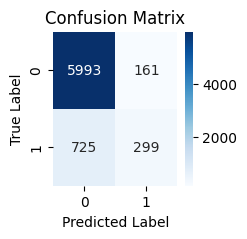

Accuracy: 0.876567

Binary Classification Report for neutral vs Others:
              precision    recall  f1-score   support

 Not neutral       0.94      0.84      0.89      5945
     neutral       0.50      0.75      0.60      1233

    accuracy                           0.83      7178
   macro avg       0.72      0.80      0.75      7178
weighted avg       0.87      0.83      0.84      7178



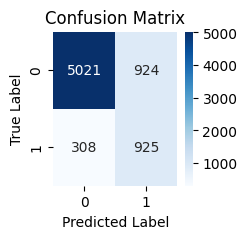

Accuracy: 0.828364

Binary Classification Report for surprise vs Others:
              precision    recall  f1-score   support

Not surprise       0.95      0.99      0.97      6347
    surprise       0.85      0.64      0.73       831

    accuracy                           0.95      7178
   macro avg       0.90      0.81      0.85      7178
weighted avg       0.94      0.95      0.94      7178



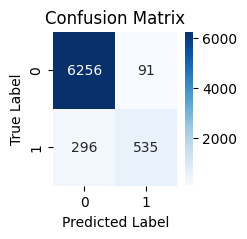

Accuracy: 0.946085


In [54]:
# Iterate over each emotion and compute binary classification metrics
for i, emotion in enumerate(EMOTION_FOLDERS):
    binary_true_labels = (np.array(y_true) == i).astype(int)  # 1 for current emotion, 0 for others
    binary_pred_labels = (np.array(y_pred) == i).astype(int)
    
    # Compute and print classification report
    print(f"\nBinary Classification Report for {emotion} vs Others:")
    print(classification_report(binary_true_labels, binary_pred_labels, target_names=[f'Not {emotion}', emotion]))

    # Generate confusion matrix
    cm = confusion_matrix(binary_true_labels, binary_pred_labels)
    
    # Plot using seaborn
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    # Compute and print accuracy to 6 decimal places
    accuracy = accuracy_score(binary_true_labels, binary_pred_labels)
    print(f"Accuracy: {accuracy:.6f}")